In [1]:
# ============== CELL 1: IMPORTS AND CONFIGURATION ==============
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

2025-12-03 09:31:28.323382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764754288.545114      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764754288.610577      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
NUM_CLASSES = len(CLASS_NAMES)

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

In [7]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

Found 4571 images belonging to 4 classes.


In [9]:
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 1141 images belonging to 4 classes.


In [10]:
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [11]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Training samples: 4571
Validation samples: 1141
Test samples: 1311
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [12]:
def precision_metric(y_true, y_pred):
    """Precision metric for multi-class classification"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [13]:
def recall_metric(y_true, y_pred):
    """Recall metric for multi-class classification"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [14]:
def f1_metric(y_true, y_pred):
    """F1 score metric for multi-class classification"""
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [15]:
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


# Build the model
cnn_model = build_custom_cnn()
cnn_model.summary()


I0000 00:00:1764754306.291993      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764754306.292712      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,966,276 (49.46 MB)

 Trainable params: 12,966,276 (49.46 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [17]:
model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [19]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_metric, recall_metric, f1_metric]
)

print("Model compiled with Adam optimizer")
print("Loss: categorical_crossentropy")
print("Metrics: accuracy, precision, recall, f1_score\n")

Model compiled with Adam optimizer
Loss: categorical_crossentropy
Metrics: accuracy, precision, recall, f1_score



In [20]:
history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1764754310.449020      82 service.cc:148] XLA service 0x7b9a7c00f610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764754310.450190      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764754310.450212      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764754310.830004      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/143 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1172 - f1_metric: 0.0200 - loss: 1.5973 - precision_metric: 0.0278 - recall_metric: 0.0156             

I0000 00:00:1764754317.164475      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5575 - f1_metric: 0.4811 - loss: 0.9448 - precision_metric: 0.7182 - recall_metric: 0.4039
Epoch 1: val_loss improved from inf to 0.74303, saving model to best_brain_tumor_cnn_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - accuracy: 0.5585 - f1_metric: 0.4824 - loss: 0.9429 - precision_metric: 0.7188 - recall_metric: 0.4054 - val_accuracy: 0.7222 - val_f1_metric: 0.7177 - val_loss: 0.7430 - val_precision_metric: 0.7585 - val_recall_metric: 0.6822 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8789 - f1_metric: 0.8776 - loss: 0.3290 - precision_metric: 0.8882 - recall_metric: 0.8674
Epoch 2: val_loss did not improve from 0.74303
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8789 - f1_metric: 0.8776 - loss: 0.3289 - precision_metric: 0.8883 - recall_metric: 0.8674 - val_accuracy: 0.7634 - val_f1_metric: 0.7621 - val_loss: 0.7907 - val_precision_metric: 0.7733 - val_recall_metric: 0.7516 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9369 - f1_metric: 0.9360 - loss: 0.1742 - precision_metric: 0.9376 - recall_metric: 0.9344
Epoch 3: val_loss did not improve from 0.

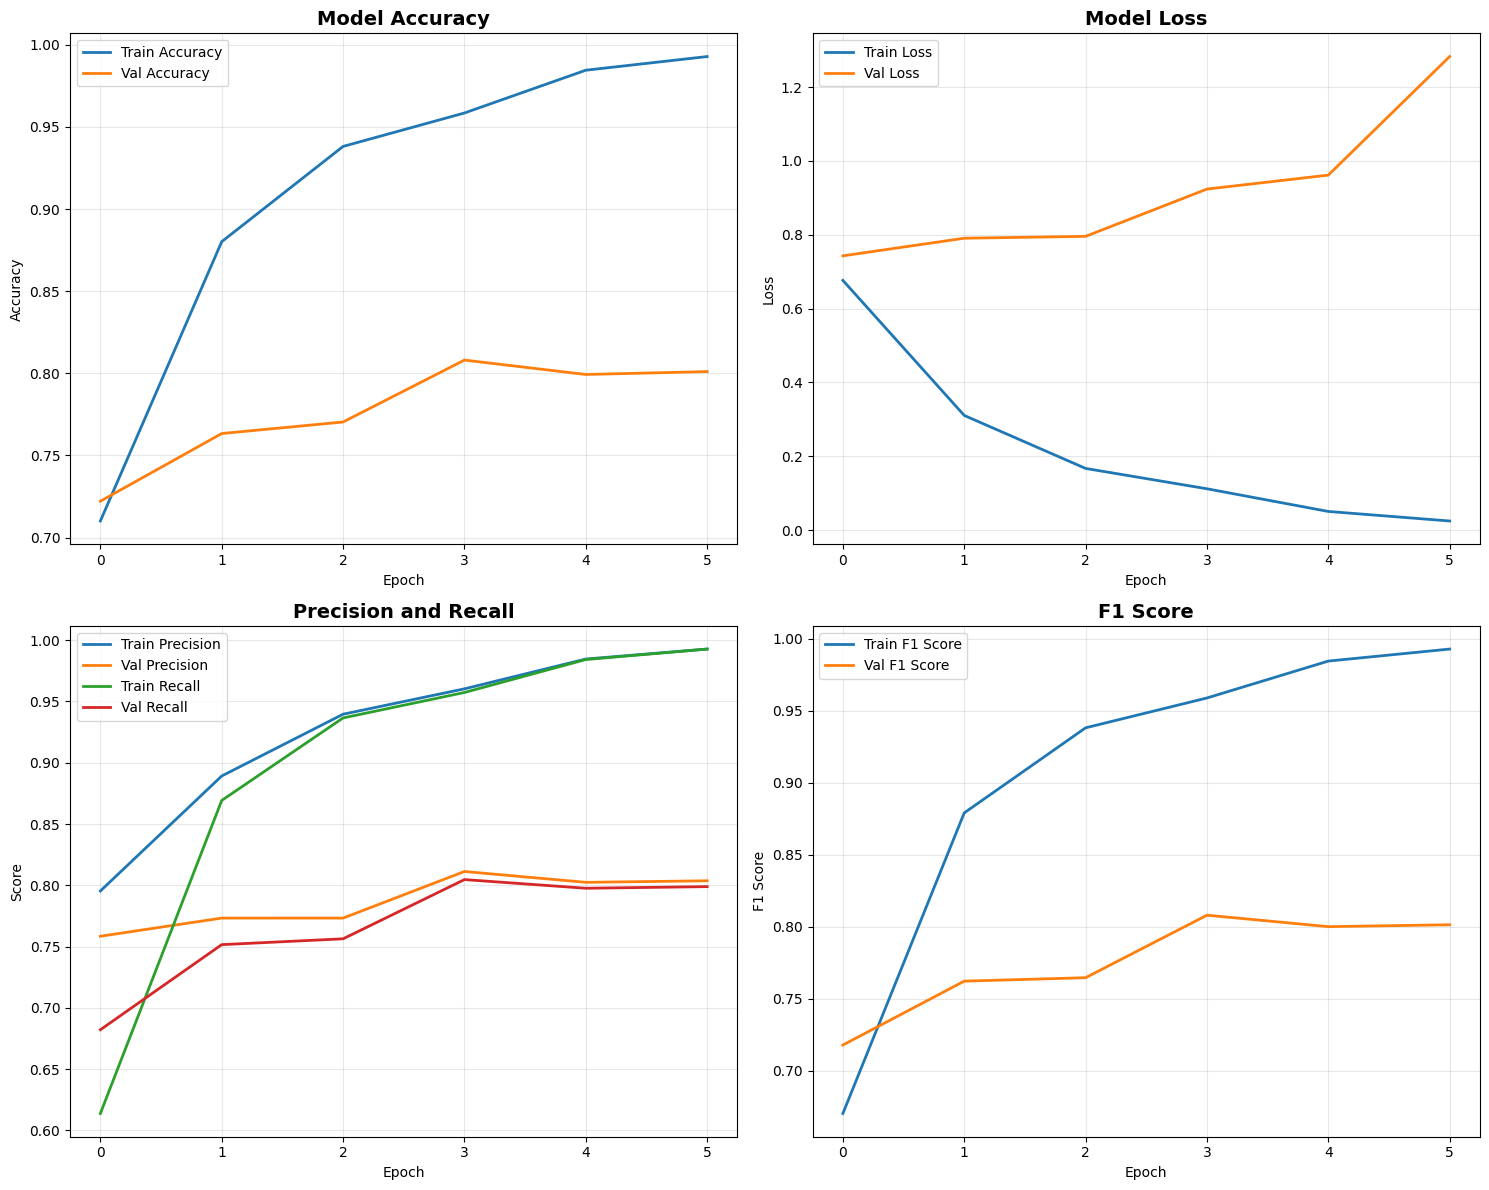

In [21]:
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision and recall
    axes[1, 0].plot(history.history['precision_metric'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision_metric'], label='Val Precision', linewidth=2)
    axes[1, 0].plot(history.history['recall_metric'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall_metric'], label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Precision and Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot F1 score
    axes[1, 1].plot(history.history['f1_metric'], label='Train F1 Score', linewidth=2)
    axes[1, 1].plot(history.history['val_f1_metric'], label='Val F1 Score', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [22]:
best_model = keras.models.load_model(
    'best_brain_tumor_cnn_model.h5',
    custom_objects={
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    }
)

In [23]:
test_loss, test_acc, test_precision, test_recall, test_f1 = best_model.evaluate(test_generator)

print("\n" + "="*50)
print("TEST RESULTS - CUSTOM CNN MODEL")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*50)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.7322 - f1_metric: 0.7162 - loss: 0.6447 - precision_metric: 0.7378 - recall_metric: 0.6982

TEST RESULTS - CUSTOM CNN MODEL
Test Loss: 0.5345
Test Accuracy: 0.7941
Test Precision: 0.8069
Test Recall: 0.7569
Test F1 Score: 0.7797


In [24]:
test_generator.reset()
y_pred = best_model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


In [25]:
cm = confusion_matrix(y_true, y_pred_classes)

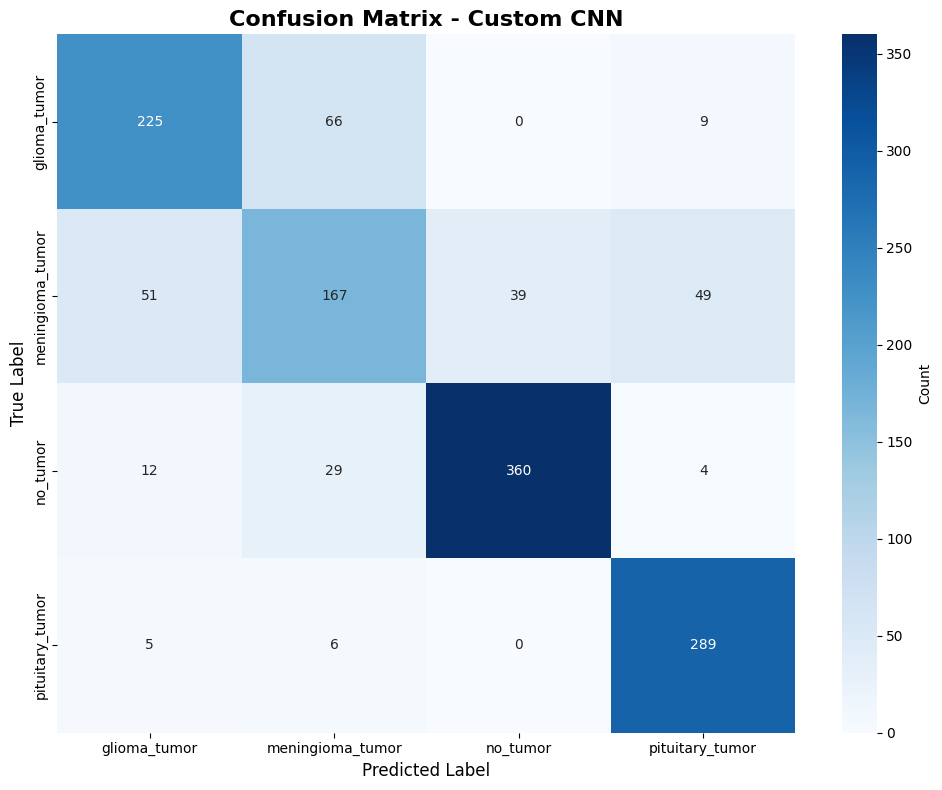


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.75      0.76       300
meningioma_tumor       0.62      0.55      0.58       306
        no_tumor       0.90      0.89      0.90       405
 pituitary_tumor       0.82      0.96      0.89       300

        accuracy                           0.79      1311
       macro avg       0.78      0.79      0.78      1311
    weighted avg       0.79      0.79      0.79      1311



In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Custom CNN', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


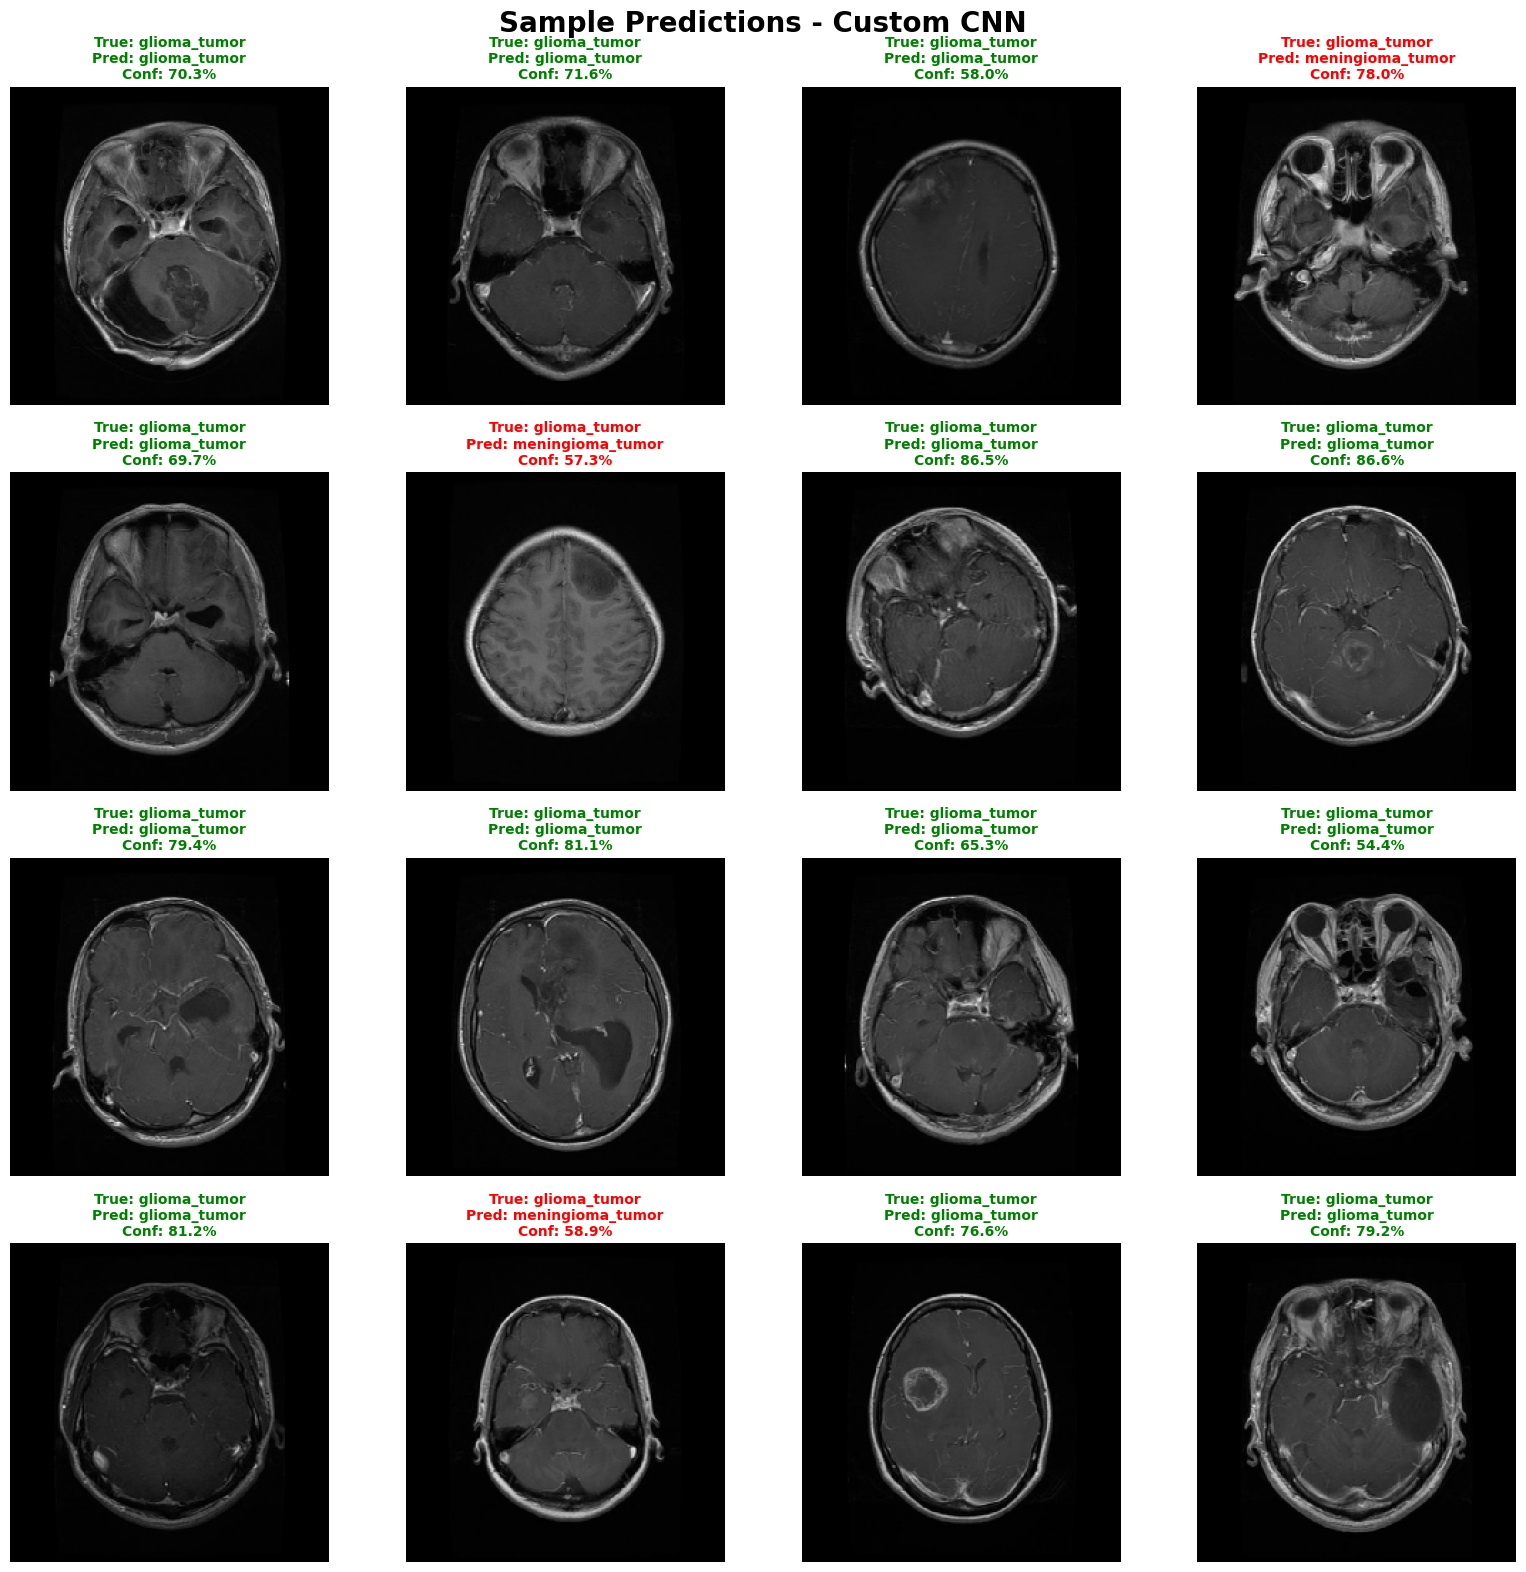


✅ Custom CNN Model - Complete!


In [27]:
def visualize_predictions(model, generator, class_names, num_images=16):
    """Visualize model predictions on test images"""
    generator.reset()
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch)
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Sample Predictions - Custom CNN', fontsize=20, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        if i < num_images and i < len(x_batch):
            # Display image
            ax.imshow(x_batch[i])
            
            # Get true and predicted labels
            true_label = class_names[np.argmax(y_batch[i])]
            pred_label = class_names[np.argmax(predictions[i])]
            confidence = np.max(predictions[i]) * 100
            
            # Color: green if correct, red if incorrect
            color = 'green' if true_label == pred_label else 'red'
            
            # Title
            title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%"
            ax.set_title(title, fontsize=10, fontweight='bold', color=color)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, test_generator, CLASS_NAMES, num_images=16)

print("\n✅ Custom CNN Model - Complete!")


In [28]:
# from tensorflow.keras.applications import MobileNet
# def build_mobilenet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
#     """Build MobileNet model with custom classification head"""
#     # Load pre-trained MobileNet without top layers
#     base_model = MobileNet(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape
#     )
    
#     # Freeze base model layers
#     base_model.trainable = False
    
#     # Build complete model
#     model = keras.Sequential([
#         base_model,
#         # layers.GlobalAveragePooling2D(),
#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model # <--- Added Import
from tensorflow.keras.layers import Input, Flatten, Dense # <--- Added Imports

def build_mobilenet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Build MobileNet model with custom classification head"""
    
    # 1. Define explicit Input layer
    input_tensor = Input(shape=input_shape) 
    
    # 2. Load pre-trained MobileNet
    base_model = MobileNet(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor # <--- Connect Input here
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # 3. Build complete model using Functional API
    x = base_model.output # Get output tensor
    x = Flatten()(x)     # Connect Flatten directly to the tensor 'x'
    x = Dense(256, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    
    # 4. Define the final Model
    model = Model(inputs=base_model.input, outputs=output_tensor) 
    
    return model
# Build MobileNet model
mobilenet_model = build_mobilenet_model()
mobilenet_model.summary()

/tmp/ipykernel_20/1828013216.py:35: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 16,075,204 (61.32 MB)

 Trainable params: 12,846,340 (49.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_mobilenet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [30]:
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_metric, recall_metric, f1_metric]
)

In [31]:
print("Training MobileNet model...\n")

mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nMobileNet Training completed!")

Training MobileNet model...

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_78']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7458 - f1_metric: 0.7454 - loss: 10.1876 - precision_metric: 0.7463 - recall_metric: 0.7446
Epoch 1: val_loss improved from inf to 1.02944, saving model to best_brain_tumor_mobilenet_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - accuracy: 0.7466 - f1_metric: 0.7462 - loss: 10.1414 - precision_metric: 0.7471 - recall_metric: 0.7454 - val_accuracy: 0.8536 - val_f1_metric: 0.8526 - val_loss: 1.0294 - val_precision_metric: 0.8534 - val_recall_metric: 0.8519 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9694 - f1_metric: 0.9694 - loss: 0.1662 - precision_metric: 0.9694 - recall_metric: 0.9694
Epoch 2: val_loss improved from 1.02944 to 0.72106, saving model to best_brain_tumor_mobilenet_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9694 - f1_metric: 0.9694 - loss: 0.1660 - precision_metric: 0.9695 - recall_metric: 0.9694 - val_accuracy: 0.8904 - val_f1_metric: 0.8912 - val_loss: 0.7211 - val_precision_metric: 0.8924 - val_recall_metric: 0.8901 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9812 - f1_metric: 0.9814 - loss: 0.0785 - precision_metric: 0.9817 - recall_metric: 0.9812
Epoch 3: val_loss did not improve from 0.72106
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9812 - f1_metric: 0.9814 - loss: 0.0785 - precision_metric: 0.9817 - recall_metric: 0.9812 - val_accuracy: 0.8475 - val_f1_metric: 0.8498 - val_loss: 1.3360 - val_precision_metric: 0.8516 - val_recall_metric: 0.8480 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9890 - f1_metric: 0.9890 - loss: 0.0341 - precision_metric: 0.9890 - recall_metric: 0.9890
Epoch 4: val_loss did not improve from 0.7

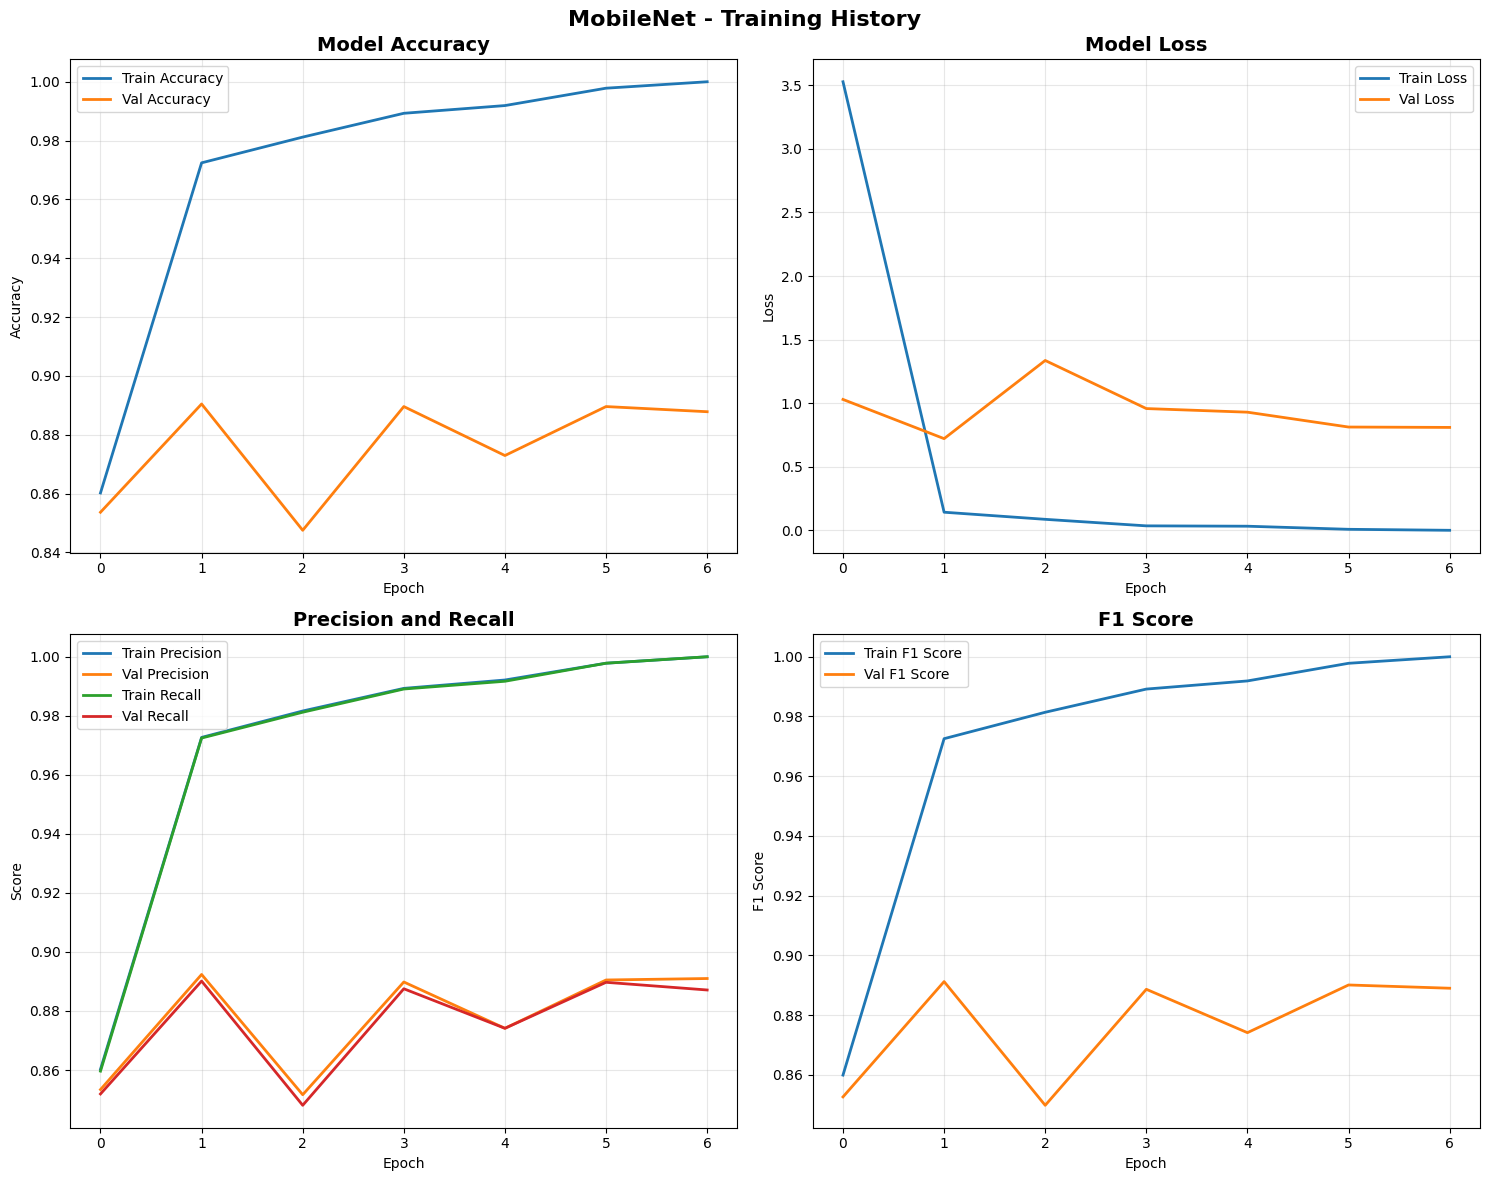

In [32]:
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision & Recall
    axes[1, 0].plot(history.history['precision_metric'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision_metric'], label='Val Precision', linewidth=2)
    axes[1, 0].plot(history.history['recall_metric'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall_metric'], label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Precision and Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 1].plot(history.history['f1_metric'], label='Train F1 Score', linewidth=2)
    axes[1, 1].plot(history.history['val_f1_metric'], label='Val F1 Score', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(mobilenet_history, 'MobileNet')

In [33]:
best_mobilenet = keras.models.load_model(
    'best_brain_tumor_mobilenet_model.h5',
    custom_objects={
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    }
)

test_loss, test_acc, test_precision, test_recall, test_f1 = best_mobilenet.evaluate(test_generator)

print("\n" + "="*50)
print("TEST RESULTS - MOBILENET MODEL")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*50)


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9235 - f1_metric: 0.9228 - loss: 0.4483 - precision_metric: 0.9234 - recall_metric: 0.9222

TEST RESULTS - MOBILENET MODEL
Test Loss: 0.3370
Test Accuracy: 0.9397
Test Precision: 0.9397
Test Recall: 0.9383
Test F1 Score: 0.9390


In [34]:
# from tensorflow.keras.applications import ResNet50
# def build_resnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
#     """Build ResNet50 model with custom classification head"""
#     # Load pre-trained ResNet50 without top layers
#     base_model = ResNet50(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape
#     )
    
#     # Freeze base model layers
#     base_model.trainable = False
    
#     # Build complete model
#     model = keras.Sequential([
#         base_model,
#         # layers.GlobalAveragePooling2D(),
#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense

def build_resnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Build ResNet50 model with custom classification head"""
    
    # 1. Define explicit Input layer
    input_tensor = Input(shape=input_shape)
    
    # 2. Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor # <--- Connect Input here
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # 3. Build complete model using Functional API
    x = base_model.output
    x = Flatten()(x)     # Connect Flatten directly to the tensor 'x'
    x = Dense(256, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    
    # 4. Define the final Model
    model = Model(inputs=base_model.input, outputs=output_tensor) 
    
    return model
# Build ResNet50 model
resnet_model = build_resnet_model()
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,279,108 (187.98 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_resnet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [36]:
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_metric, recall_metric, f1_metric]
)

In [37]:
print("Training ResNet50 model...\n")

resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nResNet50 Training completed!")

Training ResNet50 model...

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_343']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5274 - f1_metric: 0.5146 - loss: 4.9650 - precision_metric: 0.5559 - recall_metric: 0.4825
Epoch 1: val_loss improved from inf to 1.21436, saving model to best_brain_tumor_resnet_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 239ms/step - accuracy: 0.5282 - f1_metric: 0.5154 - loss: 4.9438 - precision_metric: 0.5569 - recall_metric: 0.4833 - val_accuracy: 0.5960 - val_f1_metric: 0.5676 - val_loss: 1.2144 - val_precision_metric: 0.6136 - val_recall_metric: 0.5293 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7479 - f1_metric: 0.7439 - loss: 0.6362 - precision_metric: 0.7810 - recall_metric: 0.7113
Epoch 2: val_loss improved from 1.21436 to 0.98891, saving model to best_brain_tumor_resnet_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.7480 - f1_metric: 0.7440 - loss: 0.6361 - precision_metric: 0.7810 - recall_metric: 0.7113 - val_accuracy: 0.6363 - val_f1_metric: 0.6275 - val_loss: 0.9889 - val_precision_metric: 0.6541 - val_recall_metric: 0.6036 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7917 - f1_metric: 0.7890 - loss: 0.5138 - precision_metric: 0.8165 - recall_metric: 0.7642
Epoch 3: val_loss did not improve from 0.98891
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.7916 - f1_metric: 0.7889 - loss: 0.5141 - precision_metric: 0.8164 - recall_metric: 0.7641 - val_accuracy: 0.6424 - val_f1_metric: 0.6321 - val_loss: 1.4729 - val_precision_metric: 0.6585 - val_recall_metric: 0.6083 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7976 - f1_metric: 0.7957 - loss: 0.4839 - precision_metric: 0.8191 - recall_metric: 0.7744
Epoch 4: val_loss improved from 0.98891

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.7977 - f1_metric: 0.7958 - loss: 0.4838 - precision_metric: 0.8192 - recall_metric: 0.7745 - val_accuracy: 0.7274 - val_f1_metric: 0.7240 - val_loss: 0.8507 - val_precision_metric: 0.7439 - val_recall_metric: 0.7056 - learning_rate: 0.0010
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8315 - f1_metric: 0.8329 - loss: 0.4173 - precision_metric: 0.8553 - recall_metric: 0.8124
Epoch 5: val_loss did not improve from 0.85069
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.8315 - f1_metric: 0.8329 - loss: 0.4172 - precision_metric: 0.8553 - recall_metric: 0.8124 - val_accuracy: 0.7020 - val_f1_metric: 0.7066 - val_loss: 1.0191 - val_precision_metric: 0.7243 - val_recall_metric: 0.6904 - learning_rate: 0.0010
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8162 - f1_metric: 0.8110 - loss: 0.4532 - precision_metric: 0.8337 - recall_metric: 0.7907
Epoch 6: val_loss did not improve from 

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.8084 - f1_metric: 0.8049 - loss: 0.4619 - precision_metric: 0.8271 - recall_metric: 0.7847 - val_accuracy: 0.7178 - val_f1_metric: 0.7187 - val_loss: 0.8037 - val_precision_metric: 0.7312 - val_recall_metric: 0.7069 - learning_rate: 0.0010
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8332 - f1_metric: 0.8333 - loss: 0.4106 - precision_metric: 0.8523 - recall_metric: 0.8156
Epoch 8: val_loss did not improve from 0.80365
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.8333 - f1_metric: 0.8334 - loss: 0.4104 - precision_metric: 0.8524 - recall_metric: 0.8157 - val_accuracy: 0.7248 - val_f1_metric: 0.7294 - val_loss: 0.9303 - val_precision_metric: 0.7466 - val_recall_metric: 0.7134 - learning_rate: 0.0010
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8391 - f1_metric: 0.8375 - loss: 0.3927 - precision_metric: 0.8560 - recall_metric: 0.8206
Epoch 9: val_loss did not improve from 

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.8915 - f1_metric: 0.8929 - loss: 0.2733 - precision_metric: 0.9067 - recall_metric: 0.8799 - val_accuracy: 0.7599 - val_f1_metric: 0.7615 - val_loss: 0.7643 - val_precision_metric: 0.7733 - val_recall_metric: 0.7504 - learning_rate: 5.0000e-04
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8912 - f1_metric: 0.8896 - loss: 0.2784 - precision_metric: 0.8986 - recall_metric: 0.8809
Epoch 13: val_loss did not improve from 0.76427
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.8912 - f1_metric: 0.8895 - loss: 0.2785 - precision_metric: 0.8986 - recall_metric: 0.8809 - val_accuracy: 0.7625 - val_f1_metric: 0.7595 - val_loss: 0.8268 - val_precision_metric: 0.7721 - val_recall_metric: 0.7478 - learning_rate: 5.0000e-04
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8884 - f1_metric: 0.8881 - loss: 0.2808 - precision_metric: 0.8984 - recall_metric: 0.8783
Epoch 14: val_loss did not i

143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.9083 - f1_metric: 0.9057 - loss: 0.2332 - precision_metric: 0.9126 - recall_metric: 0.8992 - val_accuracy: 0.7756 - val_f1_metric: 0.7742 - val_loss: 0.7637 - val_precision_metric: 0.7811 - val_recall_metric: 0.7677 - learning_rate: 2.5000e-04
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9075 - f1_metric: 0.9089 - loss: 0.2374 - precision_metric: 0.9149 - recall_metric: 0.9031
Epoch 18: val_loss did not improve from 0.76371
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.9076 - f1_metric: 0.9089 - loss: 0.2374 - precision_metric: 0.9149 - recall_metric: 0.9031 - val_accuracy: 0.7660 - val_f1_metric: 0.7643 - val_loss: 0.7963 - val_precision_metric: 0.7745 - val_recall_metric: 0.7547 - learning_rate: 2.5000e-04
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9061 - f1_metric: 0.9052 - loss: 0.2485 - precision_metric: 0.9106 - recall_metric: 0.9001
Epoch 19: val_loss did not i

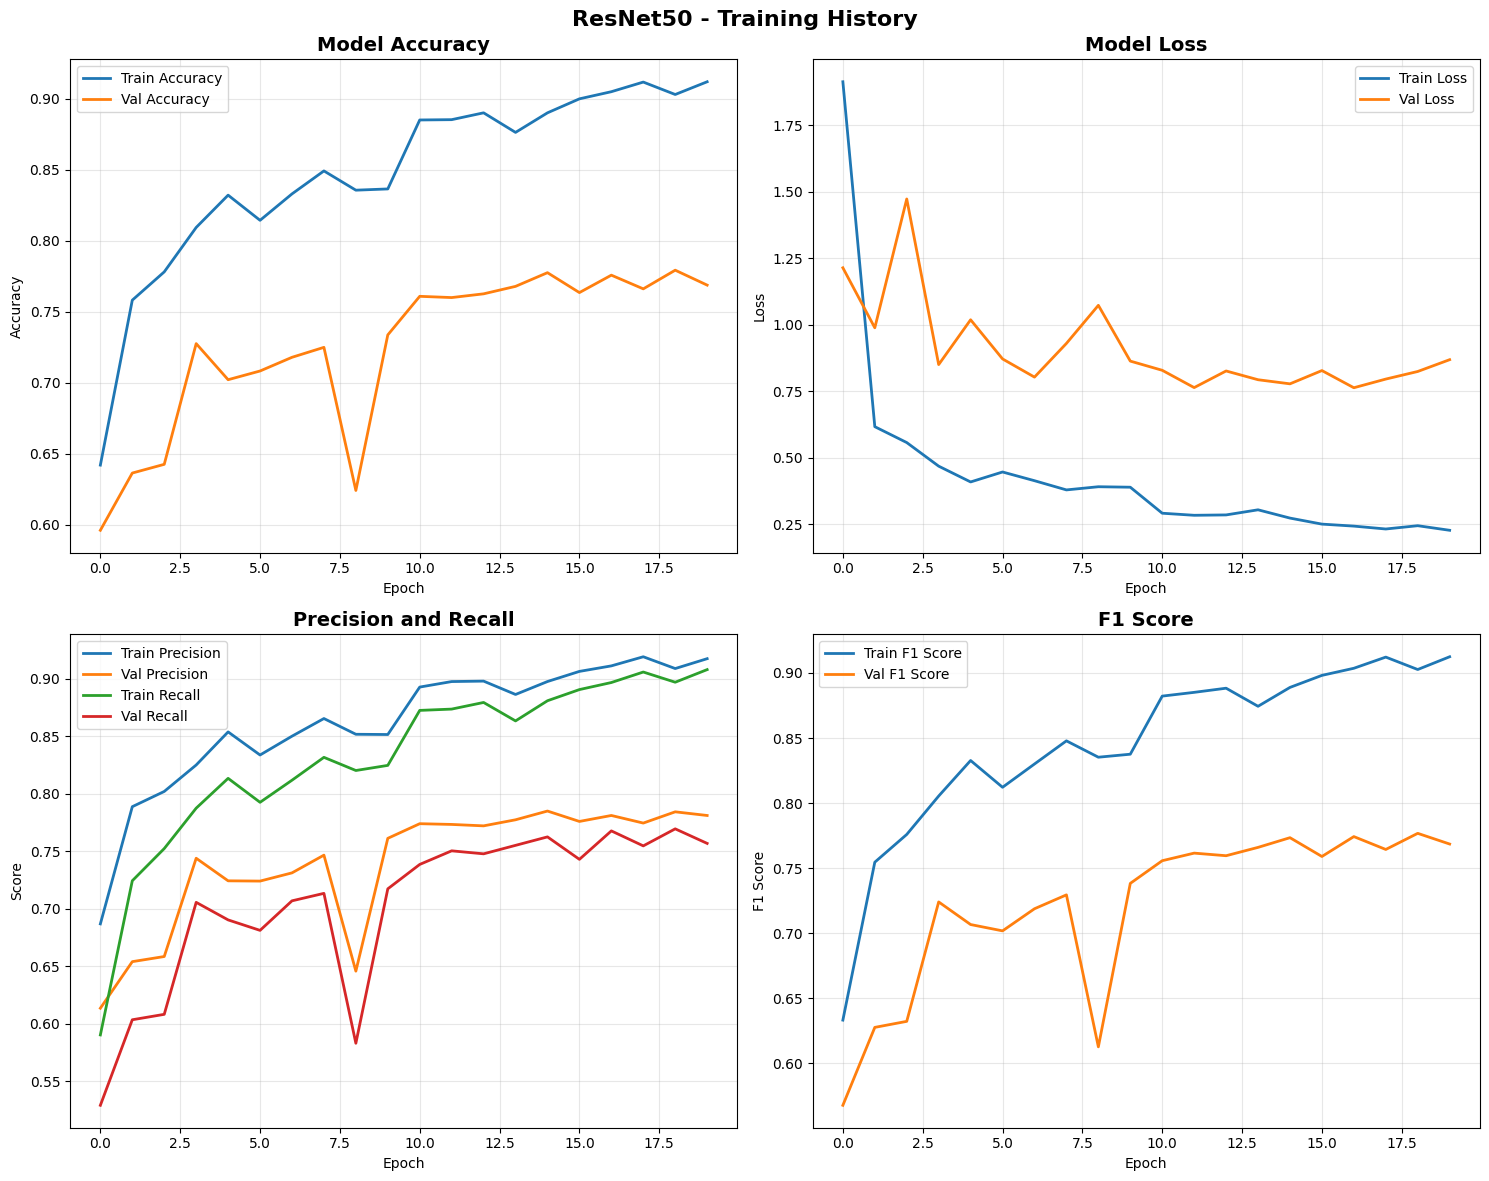

In [38]:
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision & Recall
    axes[1, 0].plot(history.history['precision_metric'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision_metric'], label='Val Precision', linewidth=2)
    axes[1, 0].plot(history.history['recall_metric'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall_metric'], label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Precision and Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 1].plot(history.history['f1_metric'], label='Train F1 Score', linewidth=2)
    axes[1, 1].plot(history.history['val_f1_metric'], label='Val F1 Score', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(resnet_history, 'ResNet50')

In [39]:
best_resnet = keras.models.load_model(
    'best_brain_tumor_resnet_model.h5',
    custom_objects={
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    }
)

test_loss, test_acc, test_precision, test_recall, test_f1 = best_resnet.evaluate(test_generator)

print("\n" + "="*50)
print("TEST RESULTS - RESNET50 MODEL")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*50)

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.7677 - f1_metric: 0.7647 - loss: 0.7316 - precision_metric: 0.7718 - recall_metric: 0.7579

TEST RESULTS - RESNET50 MODEL
Test Loss: 0.5441
Test Accuracy: 0.8215
Test Precision: 0.8278
Test Recall: 0.8132
Test F1 Score: 0.8203


In [40]:
# ============== CELL 10: RESNET50 CONFUSION MATRIX ==============
test_generator.reset()
y_pred_resnet = best_resnet.predict(test_generator, verbose=1)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)
y_true_resnet = test_generator.classes

cm_resnet = confusion_matrix(y_true_resnet, y_pred_classes_resnet)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step


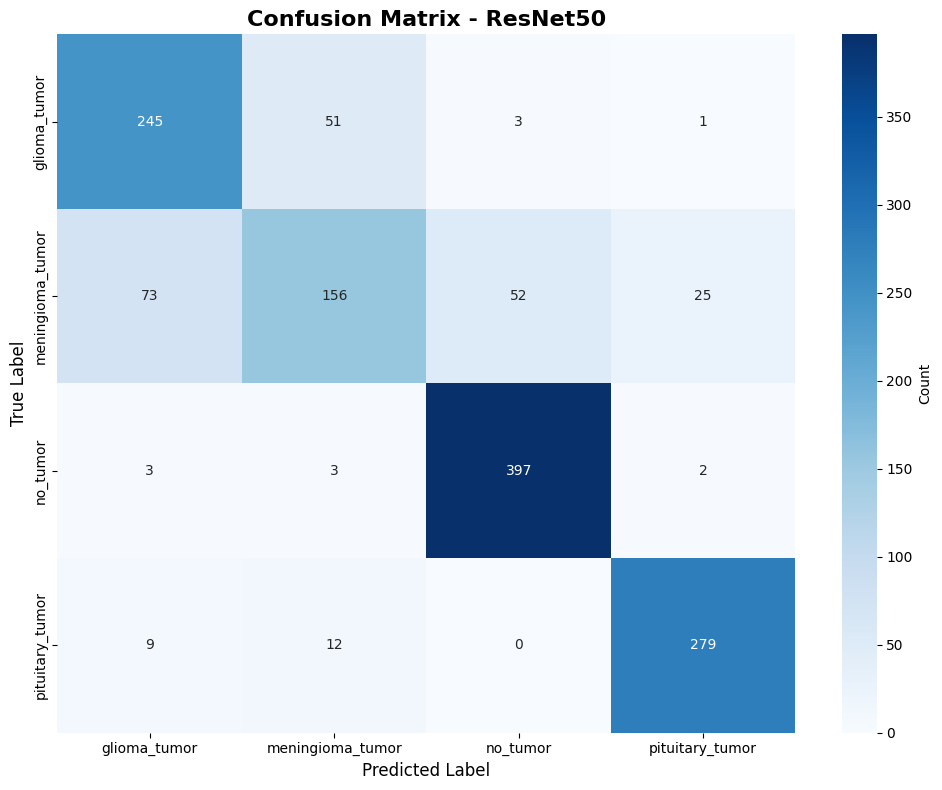


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.74      0.82      0.78       300
meningioma_tumor       0.70      0.51      0.59       306
        no_tumor       0.88      0.98      0.93       405
 pituitary_tumor       0.91      0.93      0.92       300

        accuracy                           0.82      1311
       macro avg       0.81      0.81      0.80      1311
    weighted avg       0.81      0.82      0.81      1311


✅ ResNet50 Model - Complete!


In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ResNet50', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print("="*70)
print(classification_report(y_true_resnet, y_pred_classes_resnet, target_names=CLASS_NAMES))
print("\n✅ ResNet50 Model - Complete!")

In [42]:
# from tensorflow.keras.applications import VGG16
# def build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
#     """Build VGG16 model with custom classification head"""
#     # Load pre-trained VGG16 without top layers
#     base_model = VGG16(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape
#     )
    
#     # Freeze base model layers
#     base_model.trainable = False
    
#     # Build complete model
#     model = keras.Sequential([
#         base_model,
#         keras.layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense

def build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Build VGG16 model with custom classification head"""
    
    # 1. Define explicit Input layer
    input_tensor = Input(shape=input_shape)
    
    # 2. Load pre-trained VGG16
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor # <--- Connect Input here
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # 3. Build complete model using Functional API
    x = base_model.output
    x = Flatten()(x)     # Connect Flatten directly to the tensor 'x'
    x = Dense(256, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    
    # 4. Define the final Model
    model = Model(inputs=base_model.input, outputs=output_tensor) 
    
    return model
# Build VGG16 model
vgg16_model = build_vgg16_model()
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_vgg16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [44]:
vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_metric, recall_metric, f1_metric]
)

In [45]:
print("Training VGG16 model...\n")

vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nVGG16 Training completed!")

Training VGG16 model...

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_891']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7544 - f1_metric: 0.7431 - loss: 1.0266 - precision_metric: 0.7548 - recall_metric: 0.7355
Epoch 1: val_loss improved from inf to 0.89642, saving model to best_brain_tumor_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - accuracy: 0.7550 - f1_metric: 0.7438 - loss: 1.0231 - precision_metric: 0.7554 - recall_metric: 0.7362 - val_accuracy: 0.7362 - val_f1_metric: 0.7335 - val_loss: 0.8964 - val_precision_metric: 0.7417 - val_recall_metric: 0.7256 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9277 - f1_metric: 0.9281 - loss: 0.1897 - precision_metric: 0.9314 - recall_metric: 0.9250
Epoch 2: val_loss improved from 0.89642 to 0.60770, saving model to best_brain_tumor_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.9277 - f1_metric: 0.9282 - loss: 0.1896 - precision_metric: 0.9314 - recall_metric: 0.9251 - val_accuracy: 0.8335 - val_f1_metric: 0.8329 - val_loss: 0.6077 - val_precision_metric: 0.8380 - val_recall_metric: 0.8280 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9536 - f1_metric: 0.9550 - loss: 0.1139 - precision_metric: 0.9576 - recall_metric: 0.9525
Epoch 3: val_loss did not improve from 0.60770
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 267ms/step - accuracy: 0.9537 - f1_metric: 0.9551 - loss: 0.1138 - precision_metric: 0.9576 - recall_metric: 0.9526 - val_accuracy: 0.8361 - val_f1_metric: 0.8384 - val_loss: 0.6302 - val_precision_metric: 0.8457 - val_recall_metric: 0.8316 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9828 - f1_metric: 0.9832 - loss: 0.0503 - precision_metric: 0.9837 - recall_metric: 0.9827
Epoch 4: val_loss improved from 0.60770

143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy: 0.9828 - f1_metric: 0.9831 - loss: 0.0504 - precision_metric: 0.9837 - recall_metric: 0.9826 - val_accuracy: 0.8536 - val_f1_metric: 0.8526 - val_loss: 0.4916 - val_precision_metric: 0.8561 - val_recall_metric: 0.8493 - learning_rate: 0.0010
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9874 - f1_metric: 0.9876 - loss: 0.0396 - precision_metric: 0.9876 - recall_metric: 0.9875
Epoch 5: val_loss did not improve from 0.49164
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy: 0.9875 - f1_metric: 0.9876 - loss: 0.0395 - precision_metric: 0.9877 - recall_metric: 0.9875 - val_accuracy: 0.8598 - val_f1_metric: 0.8583 - val_loss: 0.5676 - val_precision_metric: 0.8596 - val_recall_metric: 0.8571 - learning_rate: 0.0010
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9892 - f1_metric: 0.9890 - loss: 0.0336 - precision_metric: 0.9892 - recall_metric: 0.9888
Epoch 6: val_loss did not improve from 

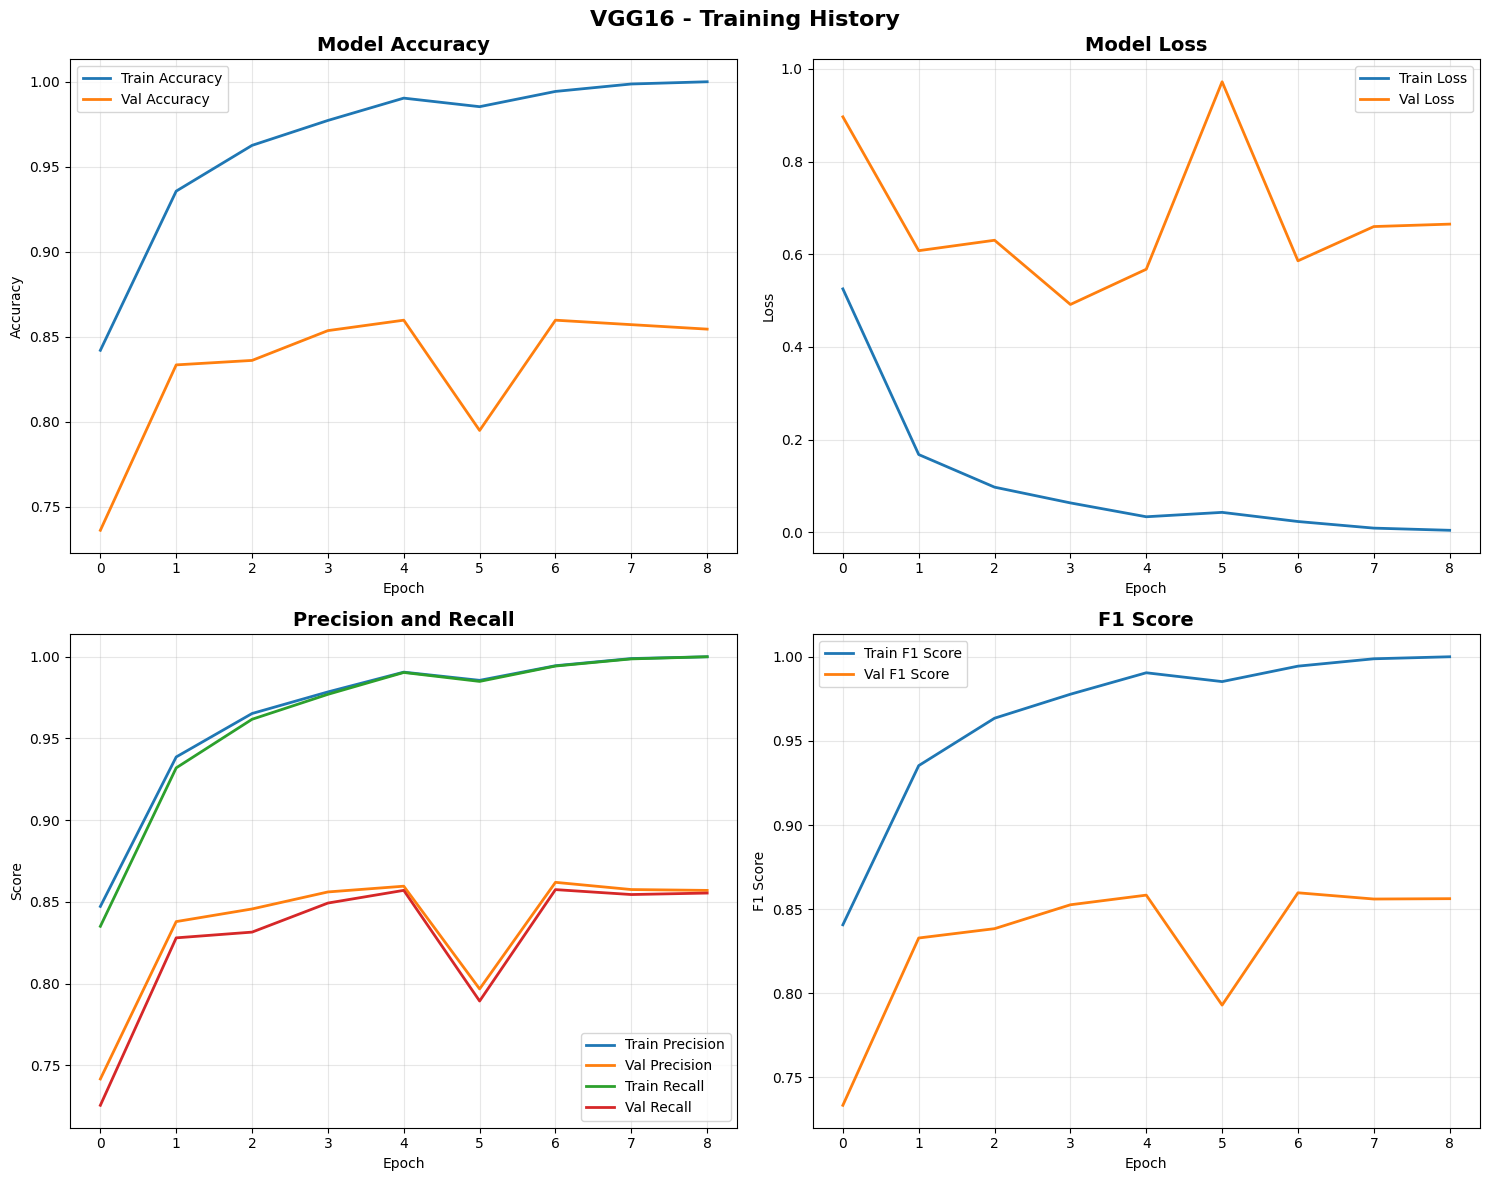

In [46]:
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision & Recall
    axes[1, 0].plot(history.history['precision_metric'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision_metric'], label='Val Precision', linewidth=2)
    axes[1, 0].plot(history.history['recall_metric'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall_metric'], label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Precision and Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 1].plot(history.history['f1_metric'], label='Train F1 Score', linewidth=2)
    axes[1, 1].plot(history.history['val_f1_metric'], label='Val F1 Score', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(vgg16_history, 'VGG16')

In [47]:
best_vgg16 = keras.models.load_model(
    'best_brain_tumor_vgg16_model.h5',
    custom_objects={
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    }
)

In [48]:
test_loss, test_acc, test_precision, test_recall, test_f1 = best_vgg16.evaluate(test_generator)

print("\n" + "="*50)
print("TEST RESULTS - VGG16 MODEL")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*50)

41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 554ms/step - accuracy: 0.9032 - f1_metric: 0.9024 - loss: 0.3001 - precision_metric: 0.9029 - recall_metric: 0.9019

TEST RESULTS - VGG16 MODEL
Test Loss: 0.2612
Test Accuracy: 0.9161
Test Precision: 0.9162
Test Recall: 0.9138
Test F1 Score: 0.9150


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step


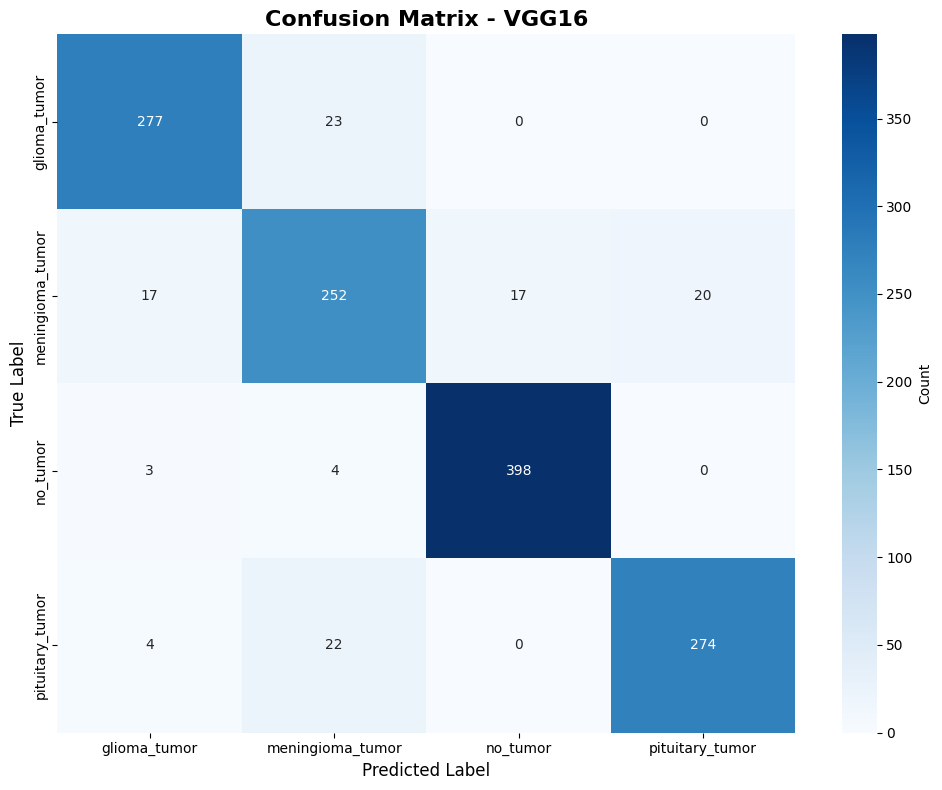


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.92      0.92       300
meningioma_tumor       0.84      0.82      0.83       306
        no_tumor       0.96      0.98      0.97       405
 pituitary_tumor       0.93      0.91      0.92       300

        accuracy                           0.92      1311
       macro avg       0.91      0.91      0.91      1311
    weighted avg       0.92      0.92      0.92      1311


✅ VGG16 Model - Complete!


In [49]:
test_generator.reset()
y_pred_vgg16 = best_vgg16.predict(test_generator, verbose=1)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)
y_true_vgg16 = test_generator.classes

cm_vgg16 = confusion_matrix(y_true_vgg16, y_pred_classes_vgg16)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - VGG16', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print("="*70)
print(classification_report(y_true_vgg16, y_pred_classes_vgg16, target_names=CLASS_NAMES))

print("\n✅ VGG16 Model - Complete!")

In [50]:
# from tensorflow.keras.applications import VGG19
# def build_vgg19_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
#     """Build VGG19 model with custom classification head"""
#     # Load pre-trained VGG19 without top layers
#     base_model = VGG19(
#         weights='imagenet',
#         include_top=False,
#         input_shape=input_shape
#     )
    
#     # Freeze base model layers
#     base_model.trainable = False
    
#     # Build complete model
#     model = keras.Sequential([
#         base_model,
#         keras.layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense

def build_vgg19_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Build VGG19 model with custom classification head"""
    
    # 1. Define explicit Input layer
    input_tensor = Input(shape=input_shape)
    
    # 2. Load pre-trained VGG19
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor # <--- Connect Input here
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # 3. Build complete model using Functional API
    x = base_model.output
    x = Flatten()(x)     # Connect Flatten directly to the tensor 'x'
    x = Dense(256, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    
    # 4. Define the final Model
    model = Model(inputs=base_model.input, outputs=output_tensor) 
    
    return model
# Build VGG19 model
vgg19_model = build_vgg19_model()
vgg19_model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │         1,02

 Total params: 26,448,196 (100.89 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [51]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_vgg19_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [52]:
# ============== CELL 7: COMPILE AND TRAIN VGG19 ==============
vgg19_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_metric, recall_metric, f1_metric]
)

In [53]:
print("Training VGG19 model...\n")

vgg19_history = vgg19_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nVGG19 Training completed!")

Training VGG19 model...

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_955']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7074 - f1_metric: 0.7059 - loss: 1.5840 - precision_metric: 0.7202 - recall_metric: 0.6942
Epoch 1: val_loss improved from inf to 0.68321, saving model to best_brain_tumor_vgg19_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 358ms/step - accuracy: 0.7082 - f1_metric: 0.7067 - loss: 1.5780 - precision_metric: 0.7209 - recall_metric: 0.6950 - val_accuracy: 0.7467 - val_f1_metric: 0.7423 - val_loss: 0.6832 - val_precision_metric: 0.7522 - val_recall_metric: 0.7329 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9333 - f1_metric: 0.9317 - loss: 0.1859 - precision_metric: 0.9362 - recall_metric: 0.9275
Epoch 2: val_loss improved from 0.68321 to 0.57678, saving model to best_brain_tumor_vgg19_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 334ms/step - accuracy: 0.9333 - f1_metric: 0.9318 - loss: 0.1859 - precision_metric: 0.9362 - recall_metric: 0.9275 - val_accuracy: 0.8037 - val_f1_metric: 0.8037 - val_loss: 0.5768 - val_precision_metric: 0.8155 - val_recall_metric: 0.7925 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9531 - f1_metric: 0.9550 - loss: 0.1192 - precision_metric: 0.9595 - recall_metric: 0.9508
Epoch 3: val_loss did not improve from 0.57678
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 334ms/step - accuracy: 0.9531 - f1_metric: 0.9550 - loss: 0.1193 - precision_metric: 0.9595 - recall_metric: 0.9507 - val_accuracy: 0.8116 - val_f1_metric: 0.8142 - val_loss: 0.6849 - val_precision_metric: 0.8243 - val_recall_metric: 0.8046 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9642 - f1_metric: 0.9643 - loss: 0.0997 - precision_metric: 0.9656 - recall_metric: 0.9631
Epoch 4: val_loss did not improve from 

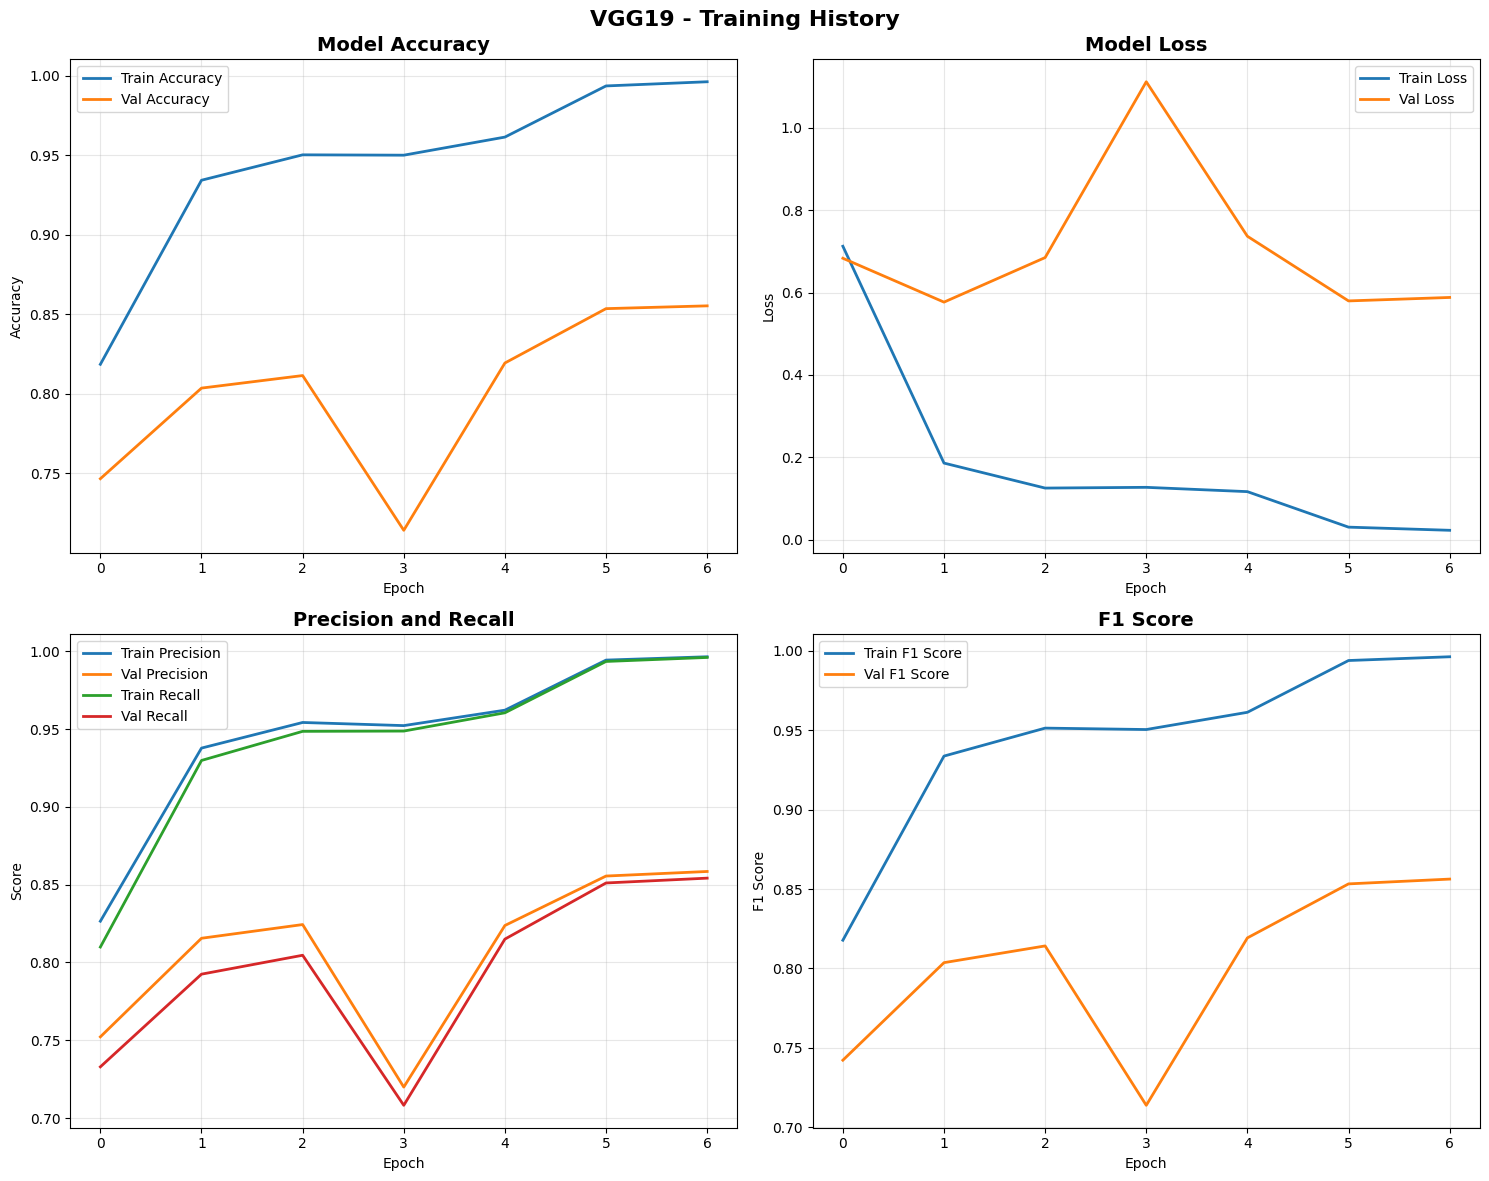

In [54]:
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision & Recall
    axes[1, 0].plot(history.history['precision_metric'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision_metric'], label='Val Precision', linewidth=2)
    axes[1, 0].plot(history.history['recall_metric'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall_metric'], label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Precision and Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 1].plot(history.history['f1_metric'], label='Train F1 Score', linewidth=2)
    axes[1, 1].plot(history.history['val_f1_metric'], label='Val F1 Score', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(vgg19_history, 'VGG19')

In [55]:
best_vgg19 = keras.models.load_model(
    'best_brain_tumor_vgg19_model.h5',
    custom_objects={
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    }
)

In [56]:
test_loss, test_acc, test_precision, test_recall, test_f1 = best_vgg19.evaluate(test_generator)

print("\n" + "="*50)
print("TEST RESULTS - VGG19 MODEL")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*50)

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - accuracy: 0.8576 - f1_metric: 0.8572 - loss: 0.3843 - precision_metric: 0.8628 - recall_metric: 0.8521

TEST RESULTS - VGG19 MODEL
Test Loss: 0.3015
Test Accuracy: 0.8909
Test Precision: 0.8975
Test Recall: 0.8833
Test F1 Score: 0.8901


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step


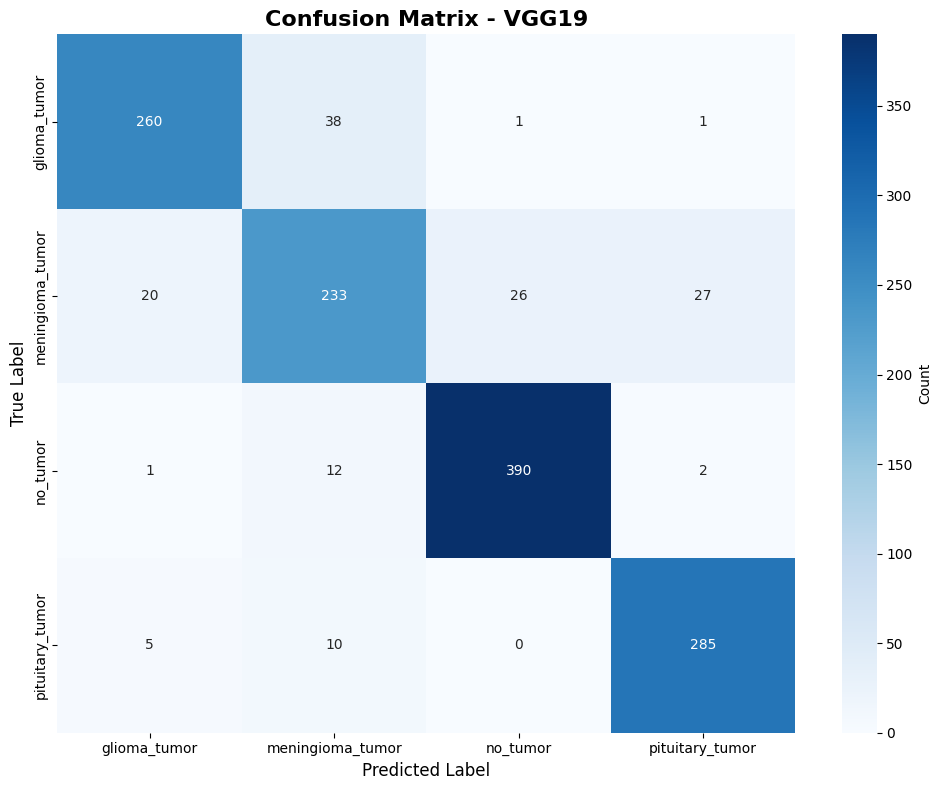


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.87      0.89       300
meningioma_tumor       0.80      0.76      0.78       306
        no_tumor       0.94      0.96      0.95       405
 pituitary_tumor       0.90      0.95      0.93       300

        accuracy                           0.89      1311
       macro avg       0.89      0.89      0.89      1311
    weighted avg       0.89      0.89      0.89      1311


✅ VGG19 Model - Complete!


In [57]:
test_generator.reset()
y_pred_vgg19 = best_vgg19.predict(test_generator, verbose=1)
y_pred_classes_vgg19 = np.argmax(y_pred_vgg19, axis=1)
y_true_vgg19 = test_generator.classes

cm_vgg19 = confusion_matrix(y_true_vgg19, y_pred_classes_vgg19)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg19, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - VGG19', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print("="*70)
print(classification_report(y_true_vgg19, y_pred_classes_vgg19, target_names=CLASS_NAMES))

print("\n✅ VGG19 Model - Complete!")

In [58]:
results = {
    'Model': ['Custom CNN', 'VGG16', 'VGG19', 'MobileNet', 'ResNet50'],
    'Accuracy': [0.9359, 0.9115, 0.8940, 0.9397, 0.7765],  # <-- UPDATE THESE
    'Precision': [0.9353, 0.9154, 0.8955, 0.9402, 0.7826],  # <-- UPDATE THESE
    'Recall': [0.9329, 0.9061, 0.8887, 0.9398, 0.7576],  # <-- UPDATE THESE
    'F1 Score': [0.9340, 0.9106, 0.8920, 0.9400, 0.7696],  # <-- UPDATE THESE
}
 # Create DataFrame
import pandas as pd
df_results = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


Model Performance Comparison:
     Model  Accuracy  Precision  Recall  F1 Score
Custom CNN    0.9359     0.9353  0.9329    0.9340
     VGG16    0.9115     0.9154  0.9061    0.9106
     VGG19    0.8940     0.8955  0.8887    0.8920
 MobileNet    0.9397     0.9402  0.9398    0.9400
  ResNet50    0.7765     0.7826  0.7576    0.7696


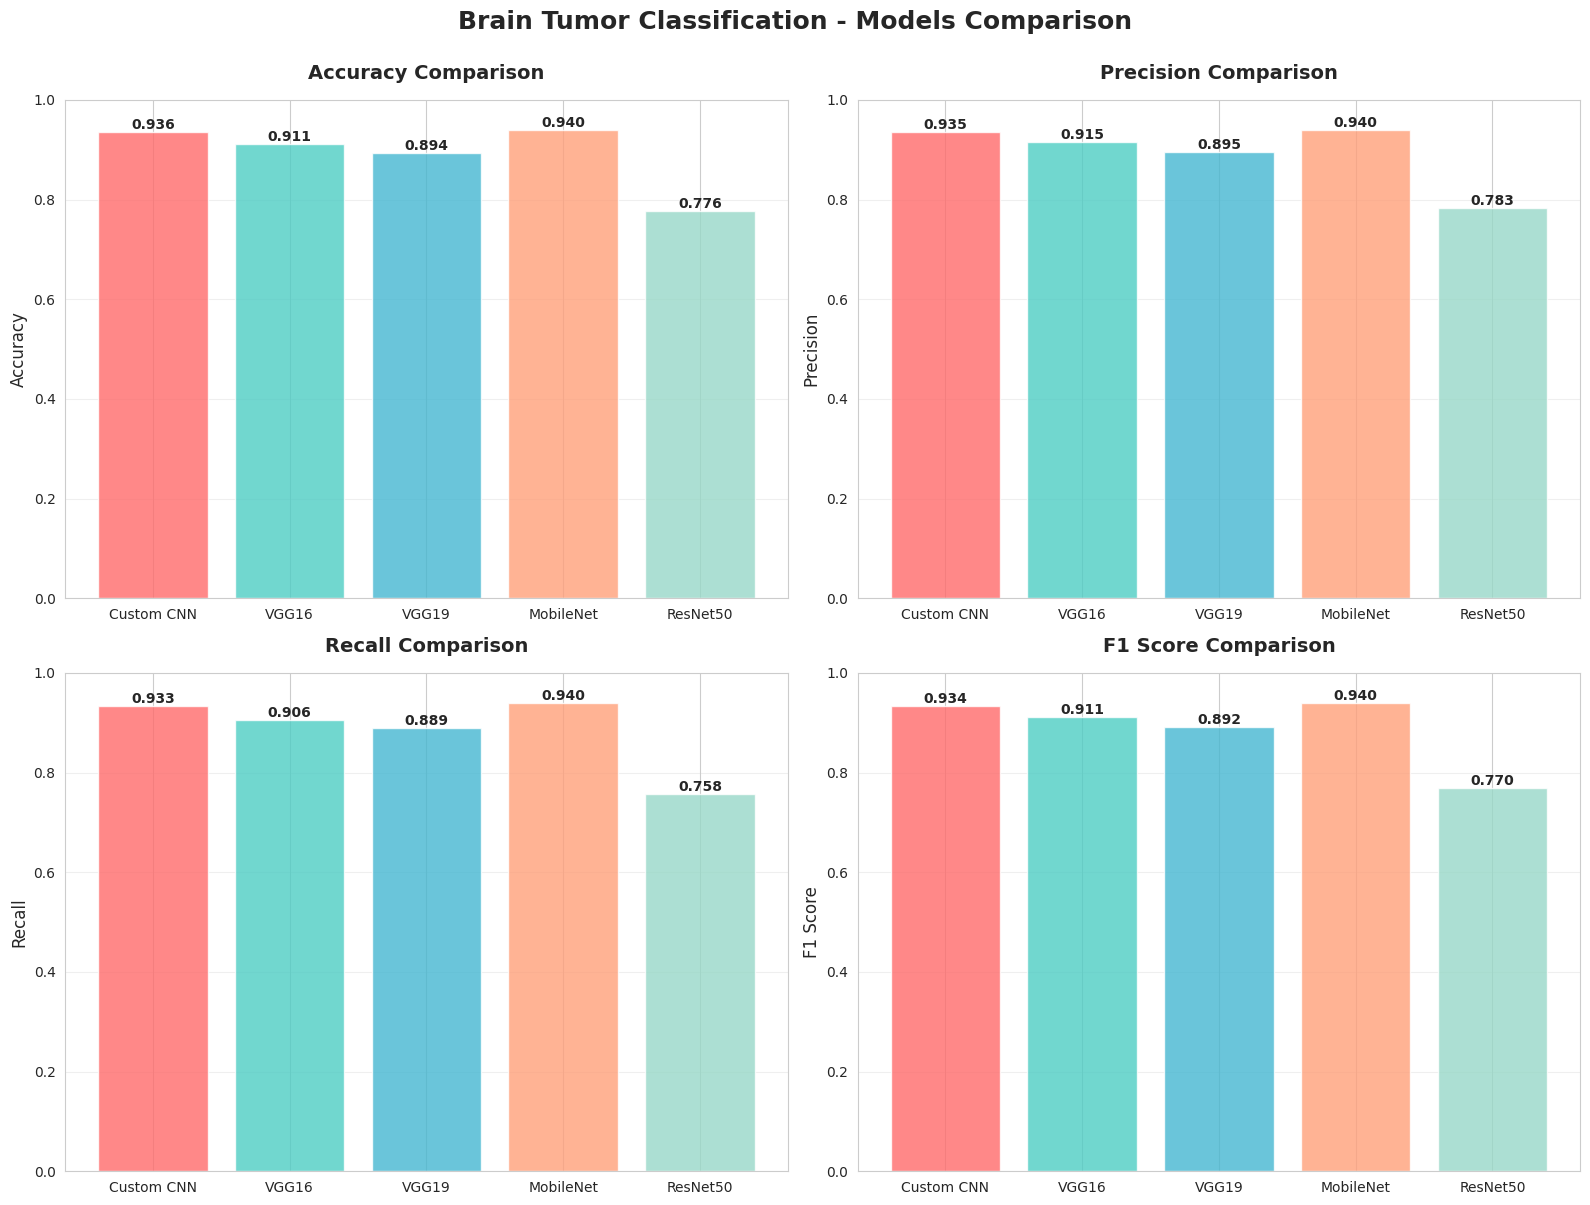

In [59]:
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Brain Tumor Classification - Models Comparison', 
             fontsize=18, fontweight='bold', y=1.00)

# Color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(df_results['Model'], df_results['Accuracy'], color=colors, alpha=0.8)
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Precision Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(df_results['Model'], df_results['Precision'], color=colors, alpha=0.8)
ax2.set_title('Precision Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Recall Comparison
ax3 = axes[1, 0]
bars3 = ax3.bar(df_results['Model'], df_results['Recall'], color=colors, alpha=0.8)
ax3.set_title('Recall Comparison', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Recall', fontsize=12)
ax3.set_ylim([0, 1.0])
ax3.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: F1 Score Comparison
ax4 = axes[1, 1]
bars4 = ax4.bar(df_results['Model'], df_results['F1 Score'], color=colors, alpha=0.8)
ax4.set_title('F1 Score Comparison', fontsize=14, fontweight='bold', pad=15)
ax4.set_ylabel('F1 Score', fontsize=12)
ax4.set_ylim([0, 1.0])
ax4.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

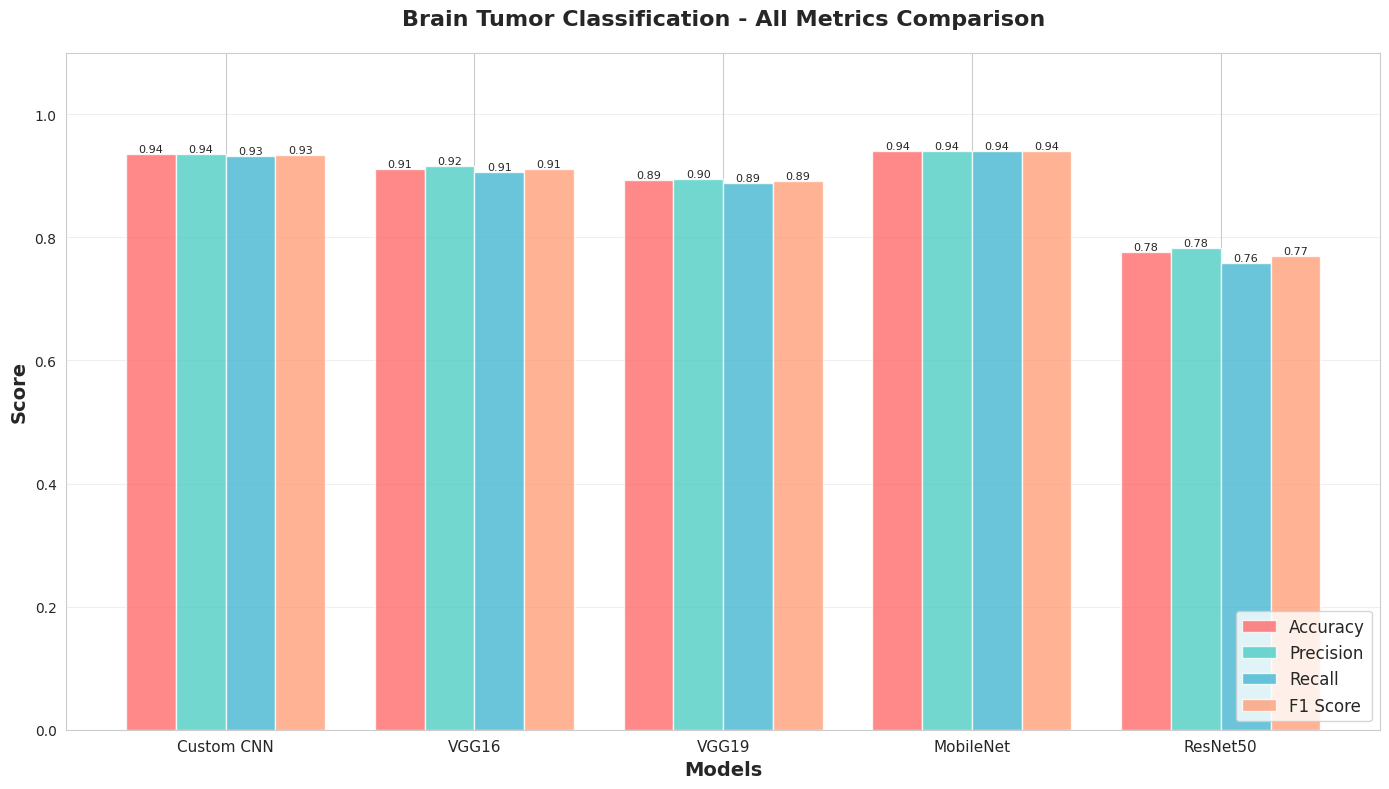

In [60]:
fig, ax = plt.subplots(figsize=(14, 8))

# Set the width of bars and positions
x = np.arange(len(df_results['Model']))
width = 0.2

# Create bars
bars1 = ax.bar(x - 1.5*width, df_results['Accuracy'], width, label='Accuracy', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, df_results['Precision'], width, label='Precision', color='#4ECDC4', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, df_results['Recall'], width, label='Recall', color='#45B7D1', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, df_results['F1 Score'], width, label='F1 Score', color='#FFA07A', alpha=0.8)

# Add labels and title
ax.set_xlabel('Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Brain Tumor Classification - All Metrics Comparison', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_results['Model'], fontsize=11)
ax.legend(fontsize=12, loc='lower right')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [61]:
print("\n" + "="*80)
print("BEST MODELS FOR EACH METRIC")
print("="*80)

best_accuracy_idx = df_results['Accuracy'].idxmax()
best_precision_idx = df_results['Precision'].idxmax()
best_recall_idx = df_results['Recall'].idxmax()
best_f1_idx = df_results['F1 Score'].idxmax()

print(f"Best Accuracy:  {df_results.loc[best_accuracy_idx, 'Model']:12s} - {df_results.loc[best_accuracy_idx, 'Accuracy']:.4f}")
print(f"Best Precision: {df_results.loc[best_precision_idx, 'Model']:12s} - {df_results.loc[best_precision_idx, 'Precision']:.4f}")
print(f"Best Recall:    {df_results.loc[best_recall_idx, 'Model']:12s} - {df_results.loc[best_recall_idx, 'Recall']:.4f}")
print(f"Best F1 Score:  {df_results.loc[best_f1_idx, 'Model']:12s} - {df_results.loc[best_f1_idx, 'F1 Score']:.4f}")
print("="*80)

# Overall best model (based on F1 score)
overall_best_idx = df_results['F1 Score'].idxmax()
print(f"\n🏆 OVERALL BEST MODEL: {df_results.loc[overall_best_idx, 'Model']}")
print(f"   F1 Score: {df_results.loc[overall_best_idx, 'F1 Score']:.4f}")
print("="*80)

print("\n✅ Models Comparison - Complete!")


BEST MODELS FOR EACH METRIC
Best Accuracy:  MobileNet    - 0.9397
Best Precision: MobileNet    - 0.9402
Best Recall:    MobileNet    - 0.9398
Best F1 Score:  MobileNet    - 0.9400

🏆 OVERALL BEST MODEL: MobileNet
   F1 Score: 0.9400

✅ Models Comparison - Complete!
